Saving 01001002757.jpg to 01001002757.jpg


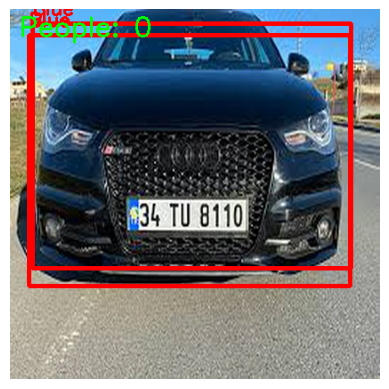

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import urllib.request
import os
from google.colab import files
import matplotlib.pyplot as plt

def download_yolo():
    if not os.path.exists("yolov3.cfg"):
        urllib.request.urlretrieve("https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg", "yolov3.cfg")
    if not os.path.exists("yolov3.weights"):
        urllib.request.urlretrieve("https://pjreddie.com/media/files/yolov3.weights", "yolov3.weights")
    if not os.path.exists("coco.names"):
        urllib.request.urlretrieve("https://github.com/pjreddie/darknet/raw/master/data/coco.names", "coco.names")

download_yolo()

yolo_net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
yolo_layer_names = yolo_net.getLayerNames()
yolo_output_layers = [yolo_layer_names[i - 1] for i in yolo_net.getUnconnectedOutLayers()]

person_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_fullbody.xml')

def detect_color(image):
    if image.shape[0] == 0 or image.shape[1] == 0:
        return [0, 0, 0]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (100, 100))
    pixels = image.reshape(-1, 3)
    kmeans = KMeans(n_clusters=3, random_state=42).fit(pixels)
    dominant_color = kmeans.cluster_centers_[np.argmax(np.bincount(kmeans.labels_))]
    return dominant_color

def classify_color(dominant_color):
    r, g, b = dominant_color
    if b > r and b > g:
        return "Blue"
    elif r > b and r > g:
        return "Red"
    elif g > r and g > b:
        return "Green"
    elif abs(r - g) < 20 and abs(g - b) < 20:
        return "Gray/Black/White"
    else:
        return "Other"

def detect_objects(image):
    height, width = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
    yolo_net.setInput(blob)
    detections = yolo_net.forward(yolo_output_layers)

    cars = []
    persons = person_cascade.detectMultiScale(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 1.1, 4)

    for detection in detections:
        for obj in detection:
            scores = obj[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5 and class_id == 2:
                center_x, center_y, w, h = (obj[:4] * np.array([width, height, width, height])).astype("int")
                x, y = int(center_x - w / 2), int(center_y - h / 2)
                cars.append((x, y, w, h))

    return cars, persons

def process_image(image):
    cars, persons = detect_objects(image)
    person_count = len(persons)
    for (x, y, w, h) in cars:
        car_roi = image[y:y+h, x:x+w]
        if car_roi.size == 0:
            continue
        dominant_color = detect_color(car_roi)
        car_color = classify_color(dominant_color)
        rectangle_color = (0, 0, 255) if car_color == "Blue" else (255, 0, 0)
        cv2.rectangle(image, (x, y), (x+w, y+h), rectangle_color, 3)
        cv2.putText(image, car_color, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, rectangle_color, 2)

    for (x, y, w, h) in persons:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

    cv2.putText(image, f'People: {person_count}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    return image

def select_image():
    uploaded = files.upload()
    for filename in uploaded.keys():
        image = cv2.imread(filename)
        processed_image = process_image(image)
        processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
        plt.imshow(processed_image)
        plt.axis('off')
        plt.show()

select_image()



Saving 01001002764.jpg to 01001002764 (1).jpg


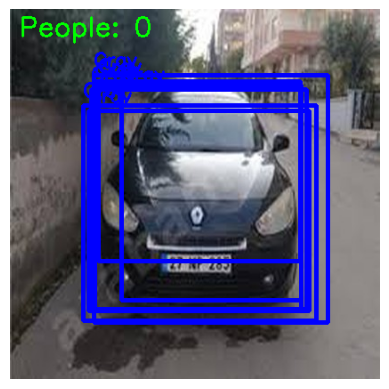

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import urllib.request
import os
from google.colab import files
import matplotlib.pyplot as plt

def download_yolo():
    if not os.path.exists("yolov3.cfg"):
        urllib.request.urlretrieve("https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg", "yolov3.cfg")
    if not os.path.exists("yolov3.weights"):
        urllib.request.urlretrieve("https://pjreddie.com/media/files/yolov3.weights", "yolov3.weights")
    if not os.path.exists("coco.names"):
        urllib.request.urlretrieve("https://github.com/pjreddie/darknet/raw/master/data/coco.names", "coco.names")

download_yolo()

yolo_net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
yolo_layer_names = yolo_net.getLayerNames()
yolo_output_layers = [yolo_layer_names[i - 1] for i in yolo_net.getUnconnectedOutLayers()]

person_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_fullbody.xml')

def detect_color(image):

    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)


    color_ranges = {
        "Red": [(0, 120, 70), (10, 255, 255)],
        "Green": [(35, 100, 100), (85, 255, 255)],
        "Blue": [(100, 150, 0), (140, 255, 255)],
        "Gray": [(0, 0, 50), (180, 50, 200)],
        "Black": [(0, 0, 0), (180, 255, 50)],
        "White": [(0, 0, 200), (180, 50, 255)]
    }


    color_count = {color: 0 for color in color_ranges}


    for color, (lower, upper) in color_ranges.items():
        lower_bound = np.array(lower)
        upper_bound = np.array(upper)
        mask = cv2.inRange(hsv_image, lower_bound, upper_bound)
        color_count[color] = cv2.countNonZero(mask)


    dominant_color = max(color_count, key=color_count.get)
    return dominant_color

def classify_color(dominant_color):

    return dominant_color

def detect_objects(image):
    height, width = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
    yolo_net.setInput(blob)
    detections = yolo_net.forward(yolo_output_layers)

    cars = []
    persons = person_cascade.detectMultiScale(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 1.1, 4)

    for detection in detections:
        for obj in detection:
            scores = obj[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5 and class_id == 2:
                center_x, center_y, w, h = (obj[:4] * np.array([width, height, width, height])).astype("int")
                x, y = int(center_x - w / 2), int(center_y - h / 2)
                cars.append((x, y, w, h))

    return cars, persons

def process_image(image):
    cars, persons = detect_objects(image)
    person_count = len(persons)
    for (x, y, w, h) in cars:
        car_roi = image[y:y+h, x:x+w]
        if car_roi.size == 0:
            continue
        dominant_color = detect_color(car_roi)
        car_color = classify_color(dominant_color)
        rectangle_color = (0, 0, 255) if car_color == "Blue" else (255, 0, 0)
        cv2.rectangle(image, (x, y), (x+w, y+h), rectangle_color, 3)
        cv2.putText(image, car_color, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, rectangle_color, 2)

    for (x, y, w, h) in persons:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

    cv2.putText(image, f'People: {person_count}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    return image

def select_image():
    uploaded = files.upload()
    for filename in uploaded.keys():
        image = cv2.imread(filename)
        processed_image = process_image(image)
        processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
        plt.imshow(processed_image)
        plt.axis('off')
        plt.show()

select_image()


Saving 01001002769.jpg to 01001002769.jpg


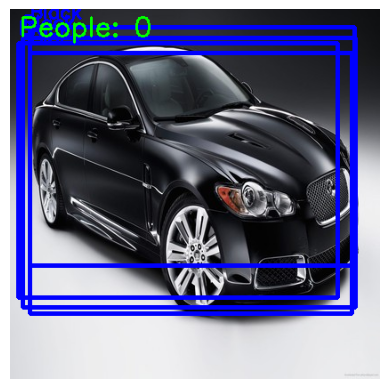

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import urllib.request
import os
from google.colab import files
import matplotlib.pyplot as plt

def download_yolo():
    if not os.path.exists("yolov3.cfg"):
        urllib.request.urlretrieve("https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg", "yolov3.cfg")
    if not os.path.exists("yolov3.weights"):
        urllib.request.urlretrieve("https://pjreddie.com/media/files/yolov3.weights", "yolov3.weights")
    if not os.path.exists("coco.names"):
        urllib.request.urlretrieve("https://github.com/pjreddie/darknet/raw/master/data/coco.names", "coco.names")

download_yolo()

yolo_net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
yolo_layer_names = yolo_net.getLayerNames()
yolo_output_layers = [yolo_layer_names[i - 1] for i in yolo_net.getUnconnectedOutLayers()]

person_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_fullbody.xml')

def detect_color(image):

    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)


    color_ranges = {
        "Red": [(0, 120, 70), (10, 255, 255)],
        "Green": [(35, 100, 100), (85, 255, 255)],
        "Blue": [(100, 150, 0), (140, 255, 255)],
        "Gray": [(0, 0, 50), (180, 50, 200)],
        "Black": [(0, 0, 0), (180, 255, 50)],
        "White": [(0, 0, 200), (180, 50, 255)]
    }


    color_count = {color: 0 for color in color_ranges}


    for color, (lower, upper) in color_ranges.items():
        lower_bound = np.array(lower)
        upper_bound = np.array(upper)
        mask = cv2.inRange(hsv_image, lower_bound, upper_bound)
        color_count[color] = cv2.countNonZero(mask)


    dominant_color = max(color_count, key=color_count.get)
    return dominant_color

def classify_color(dominant_color):

    return dominant_color

def detect_objects(image):
    height, width = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
    yolo_net.setInput(blob)
    detections = yolo_net.forward(yolo_output_layers)

    cars = []
    persons = person_cascade.detectMultiScale(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 1.1, 4)

    for detection in detections:
        for obj in detection:
            scores = obj[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5 and class_id == 2:
                center_x, center_y, w, h = (obj[:4] * np.array([width, height, width, height])).astype("int")
                x, y = int(center_x - w / 2), int(center_y - h / 2)
                cars.append((x, y, w, h))

    return cars, persons

def process_image(image):
    cars, persons = detect_objects(image)
    person_count = len(persons)
    for (x, y, w, h) in cars:
        car_roi = image[y:y+h, x:x+w]
        if car_roi.size == 0:
            continue
        dominant_color = detect_color(car_roi)
        car_color = classify_color(dominant_color)
        rectangle_color = (0, 0, 255) if car_color == "Blue" else (255, 0, 0)
        cv2.rectangle(image, (x, y), (x+w, y+h), rectangle_color, 3)
        cv2.putText(image, car_color, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, rectangle_color, 2)

    for (x, y, w, h) in persons:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

    cv2.putText(image, f'People: {person_count}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    return image

def select_image():
    uploaded = files.upload()
    for filename in uploaded.keys():
        image = cv2.imread(filename)
        processed_image = process_image(image)
        processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
        plt.imshow(processed_image)
        plt.axis('off')
        plt.show()

select_image()


Saving 01001002754.jpg to 01001002754 (1).jpg


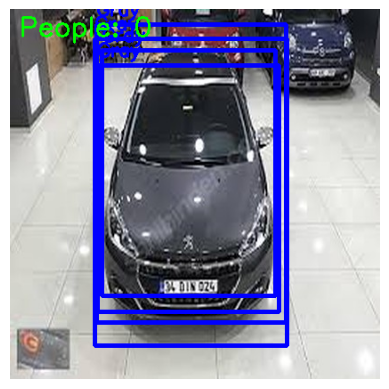

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import urllib.request
import os
from google.colab import files
import matplotlib.pyplot as plt

def download_yolo():
    if not os.path.exists("yolov3.cfg"):
        urllib.request.urlretrieve("https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg", "yolov3.cfg")
    if not os.path.exists("yolov3.weights"):
        urllib.request.urlretrieve("https://pjreddie.com/media/files/yolov3.weights", "yolov3.weights")
    if not os.path.exists("coco.names"):
        urllib.request.urlretrieve("https://github.com/pjreddie/darknet/raw/master/data/coco.names", "coco.names")

download_yolo()

yolo_net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
yolo_layer_names = yolo_net.getLayerNames()
yolo_output_layers = [yolo_layer_names[i - 1] for i in yolo_net.getUnconnectedOutLayers()]

person_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_fullbody.xml')

def detect_color(image):

    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)


    color_ranges = {
        "Red": [(0, 120, 70), (10, 255, 255)],
        "Green": [(35, 100, 100), (85, 255, 255)],
        "Blue": [(100, 150, 0), (140, 255, 255)],
        "Gray": [(0, 0, 50), (180, 50, 200)],
        "Black": [(0, 0, 0), (180, 255, 50)],
        "White": [(0, 0, 200), (180, 50, 255)]
    }


    color_count = {color: 0 for color in color_ranges}


    for color, (lower, upper) in color_ranges.items():
        lower_bound = np.array(lower)
        upper_bound = np.array(upper)
        mask = cv2.inRange(hsv_image, lower_bound, upper_bound)
        color_count[color] = cv2.countNonZero(mask)


    dominant_color = max(color_count, key=color_count.get)
    return dominant_color

def classify_color(dominant_color):

    return dominant_color

def detect_objects(image):
    height, width = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
    yolo_net.setInput(blob)
    detections = yolo_net.forward(yolo_output_layers)

    cars = []
    persons = person_cascade.detectMultiScale(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 1.1, 4)

    for detection in detections:
        for obj in detection:
            scores = obj[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5 and class_id == 2:
                center_x, center_y, w, h = (obj[:4] * np.array([width, height, width, height])).astype("int")
                x, y = int(center_x - w / 2), int(center_y - h / 2)
                cars.append((x, y, w, h))

    return cars, persons

def process_image(image):
    cars, persons = detect_objects(image)
    person_count = len(persons)
    for (x, y, w, h) in cars:
        car_roi = image[y:y+h, x:x+w]
        if car_roi.size == 0:
            continue
        dominant_color = detect_color(car_roi)
        car_color = classify_color(dominant_color)
        rectangle_color = (0, 0, 255) if car_color == "Blue" else (255, 0, 0)
        cv2.rectangle(image, (x, y), (x+w, y+h), rectangle_color, 3)
        cv2.putText(image, car_color, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, rectangle_color, 2)

    for (x, y, w, h) in persons:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

    cv2.putText(image, f'People: {person_count}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    return image

def select_image():
    uploaded = files.upload()
    for filename in uploaded.keys():
        image = cv2.imread(filename)
        processed_image = process_image(image)
        processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
        plt.imshow(processed_image)
        plt.axis('off')
        plt.show()

select_image()


Saving 01001002717.jpg to 01001002717.jpg


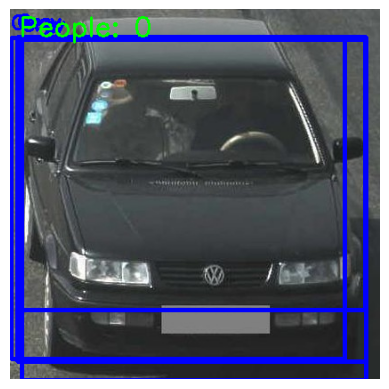

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import urllib.request
import os
from google.colab import files
import matplotlib.pyplot as plt

def download_yolo():
    if not os.path.exists("yolov3.cfg"):
        urllib.request.urlretrieve("https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg", "yolov3.cfg")
    if not os.path.exists("yolov3.weights"):
        urllib.request.urlretrieve("https://pjreddie.com/media/files/yolov3.weights", "yolov3.weights")
    if not os.path.exists("coco.names"):
        urllib.request.urlretrieve("https://github.com/pjreddie/darknet/raw/master/data/coco.names", "coco.names")

download_yolo()

yolo_net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
yolo_layer_names = yolo_net.getLayerNames()
yolo_output_layers = [yolo_layer_names[i - 1] for i in yolo_net.getUnconnectedOutLayers()]

person_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_fullbody.xml')

def detect_color(image):

    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)


    color_ranges = {
        "Red": [(0, 120, 70), (10, 255, 255)],
        "Green": [(35, 100, 100), (85, 255, 255)],
        "Blue": [(100, 150, 0), (140, 255, 255)],
        "Gray": [(0, 0, 50), (180, 50, 200)],
        "Black": [(0, 0, 0), (180, 255, 50)],
        "White": [(0, 0, 200), (180, 50, 255)]
    }


    color_count = {color: 0 for color in color_ranges}


    for color, (lower, upper) in color_ranges.items():
        lower_bound = np.array(lower)
        upper_bound = np.array(upper)
        mask = cv2.inRange(hsv_image, lower_bound, upper_bound)
        color_count[color] = cv2.countNonZero(mask)


    dominant_color = max(color_count, key=color_count.get)
    return dominant_color

def classify_color(dominant_color):

    return dominant_color

def detect_objects(image):
    height, width = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
    yolo_net.setInput(blob)
    detections = yolo_net.forward(yolo_output_layers)

    cars = []
    persons = person_cascade.detectMultiScale(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 1.1, 4)

    for detection in detections:
        for obj in detection:
            scores = obj[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5 and class_id == 2:  # Class 2 is 'car' in COCO dataset
                center_x, center_y, w, h = (obj[:4] * np.array([width, height, width, height])).astype("int")
                x, y = int(center_x - w / 2), int(center_y - h / 2)
                cars.append((x, y, w, h))

    return cars, persons

def process_image(image):
    cars, persons = detect_objects(image)
    person_count = len(persons)
    for (x, y, w, h) in cars:
        car_roi = image[y:y+h, x:x+w]
        if car_roi.size == 0:
            continue
        dominant_color = detect_color(car_roi)
        car_color = classify_color(dominant_color)


        rectangle_color = (0, 0, 255) if car_color == "Blue" else (255, 0, 0)

        cv2.rectangle(image, (x, y), (x+w, y+h), rectangle_color, 3)
        cv2.putText(image, car_color, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, rectangle_color, 2)

    for (x, y, w, h) in persons:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

    cv2.putText(image, f'People: {person_count}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    return image

def select_image():
    uploaded = files.upload()
    for filename in uploaded.keys():
        image = cv2.imread(filename)
        processed_image = process_image(image)
        processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
        plt.imshow(processed_image)
        plt.axis('off')
        plt.show()

select_image()
